In [2]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm

print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v5.1.2


In [18]:
RANDOM_SEED = 2022

In [3]:
import pymc_bart as pmb

In [4]:
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import (roc_curve, roc_auc_score, confusion_matrix, accuracy_score, f1_score, precision_recall_curve) 
from sklearn.datasets import make_classification

In [5]:
features, output = make_classification(n_samples = 500, n_features = 10, n_informative = 6, n_redundant = 4, n_classes = 2, random_state = 2022)
X = pd.DataFrame(features, columns=["feature_1", "feature_2", "feature_3", "feature_4", "feature_5", "feature_6", "feature_7", "feature_8", "feature_9", "feature_10"])
y = output

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)


In [25]:
with pm.Model() as model_oos_ts:
    X = pm.MutableData("X", X_train)
    Y = y_train
    α = pm.Exponential("α", 1 / 10)
    μ = pmb.BART("μ", X, Y)
    y = pm.NegativeBinomial("y", mu=pm.math.abs(μ), alpha=α, observed=Y, shape=μ.shape)
    idata_oos_ts = pm.sample(random_seed=RANDOM_SEED)
    posterior_predictive_oos_ts_train = pm.sample_posterior_predictive(
        trace=idata_oos_ts, random_seed=RANDOM_SEED
    )

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [α]
>PGBART: [μ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 124 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [y]


In [26]:
with model_oos_ts:
    X.set_value(X_test)
    posterior_predictive_oos_ts_test = pm.sample_posterior_predictive(
        trace=idata_oos_ts, random_seed=RANDOM_SEED
    )

Sampling: [y, μ]


In [29]:
y_score = posterior_predictive_oos_ts_test['posterior_predictive']['y'].mean(('chain', 'draw'))

In [30]:
y_pred_cat = np.where(y_score >= 0.5, 1, 0)

In [31]:
print(roc_auc_score(y_pred_cat, y_test))
print(confusion_matrix(y_pred_cat, y_test))

0.8606060606060605
[[47  8]
 [ 6 39]]


0.577


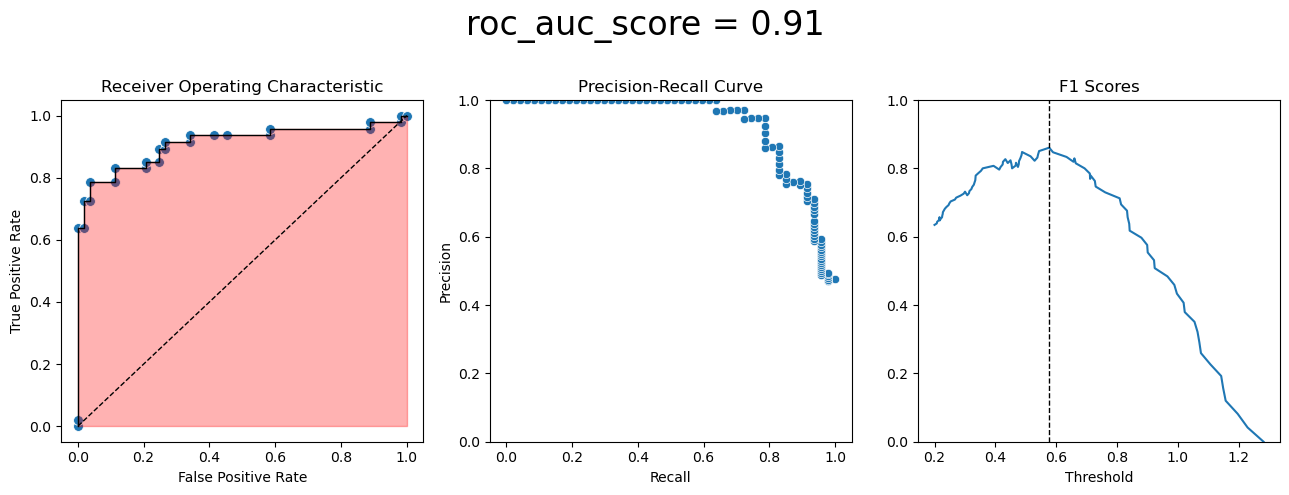

In [32]:
pred_scores = dict(y_true=y_test, y_score=y_score)
cols = ['False Positive Rate', 'True Positive Rate', 'threshold']
roc = pd.DataFrame(dict(zip(cols, roc_curve(**pred_scores))))

precision, recall, ts = precision_recall_curve(y_true=y_test, probas_pred=y_score)
pr_curve = pd.DataFrame({'Precision': precision, 'Recall': recall})

f1 = pd.Series({t: f1_score(y_true=y_test, y_pred=y_score>t) for t in ts})
best_threshold = f1.idxmax()
print(best_threshold)

fig, axes = plt.subplots(ncols=3, figsize=(13, 5))

ax = sns.scatterplot(x='False Positive Rate', y='True Positive Rate', data=roc, s=50, legend=False, ax=axes[0])
axes[0].plot('False Positive Rate', 'True Positive Rate', data=roc, lw=1, color='k')
axes[0].plot(np.linspace(0,1,100), np.linspace(0,1,100), color='k', ls='--', lw=1)
axes[0].fill_between(y1=roc['True Positive Rate'], x=roc['False Positive Rate'], alpha=.3, color='red')
axes[0].set_title('Receiver Operating Characteristic')


sns.scatterplot(x='Recall', y='Precision', data=pr_curve, ax=axes[1])
axes[1].set_ylim(0,1)
axes[1].set_title('Precision-Recall Curve')


f1.plot(ax=axes[2], title='F1 Scores', ylim=(0,1))
axes[2].set_xlabel('Threshold')
axes[2].axvline(best_threshold, lw=1, ls='--', color='k')
#axes[2].text(text=f'Max F1 @ {best_threshold:.2f}', x=.60, y=.95, s=5)
    
fig.suptitle(f'roc_auc_score = {round(roc_auc_score(**pred_scores),2)}', fontsize=24)
fig.tight_layout()
fig.savefig("roc.png")
plt.subplots_adjust(top=.8)
plt.show()

In [33]:
with pm.Model() as model_coal:
    
    #X = pm.Data("X", value = X_train, mutable = True)
    #y = pm.Data("y", value = y_train, mutable = True)
    
    
    
    X = pm.MutableData("X", X_train)
    Y = y_train
    
    μ = pmb.BART("μ_", X, Y, m=20)
    y_pred = pm.Poisson("y_pred", mu=pm.math.abs(μ), observed=y_train, shape = μ.shape)
    idata_coal = pm.sample(random_seed=2022)

Multiprocess sampling (4 chains in 4 jobs)
PGBART: [μ_]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 60 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [34]:
with model_coal:
    X.set_value(X_test)
    posterior_predictive_oos_regression_test = pm.sample_posterior_predictive(
        trace=idata_coal, random_seed=2022
    )

Sampling: [y_pred, μ_]


In [36]:
y_pred = posterior_predictive_oos_regression_test['posterior_predictive']['y_pred'].mean(('chain', 'draw'))

In [37]:
y_pred_cat = np.where(y_score >= 0.5, 1, 0)
print(roc_auc_score(y_pred_cat, y_test))
print(confusion_matrix(y_pred_cat, y_test))

0.8606060606060605
[[47  8]
 [ 6 39]]


In [11]:
import sys

In [12]:
sys.version

'3.9.13 (main, Aug 25 2022, 23:51:50) [MSC v.1916 64 bit (AMD64)]'

In [1]:
pip freeze

absl-py==1.3.0
aeppl==0.0.38
aesara==2.8.7
alabaster @ file:///home/ktietz/src/ci/alabaster_1611921544520/work
anaconda-client==1.11.0
anaconda-navigator==2.3.1
anaconda-project @ file:///C:/Windows/TEMP/abs_91fu4tfkih/croots/recipe/anaconda-project_1660339890874/work
anyio @ file:///C:/ci/anyio_1644481921011/work/dist
appdirs==1.4.4
argon2-cffi @ file:///opt/conda/conda-bld/argon2-cffi_1645000214183/work
argon2-cffi-bindings @ file:///C:/ci/argon2-cffi-bindings_1644551690056/work
arrow @ file:///opt/conda/conda-bld/arrow_1649166651673/work
arviz==0.13.0
astroid @ file:///C:/Windows/TEMP/abs_b0dtxgpicv/croots/recipe/astroid_1659023126745/work
astropy @ file:///C:/ci/astropy_1657719656942/work
astunparse==1.6.3
atomicwrites==1.4.0
attrs @ file:///opt/conda/conda-bld/attrs_1642510447205/work
Automat @ file:///tmp/build/80754af9/automat_1600298431173/work
autopep8 @ file:///opt/conda/conda-bld/autopep8_1650463822033/work
Babel @ file:///tmp/build/80754af9/babel_1620871417480/work
backcall